# Natural Scenes Classification: ResNet50, EfficientNetV2, VGG16

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
from glob import glob
import cv2
import tensorflow as tf

A list of available pretrained models (for image processing applications) can be found here:

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B2, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

In [5]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.ckpt',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
]

# Loading images 

Some information about the dataset is included here for clarity:

This dataset contains around 25k images of size 150x150 distributed under 6 categories.

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [6]:
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
test_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.25,
                                  validation_split=0.2,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip = True,  
                                  vertical_flip = False,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    subset='training',
    shuffle=True,
    class_mode="categorical",
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=128,
    shuffle=False,
    class_mode="categorical",
)

Found 3000 images belonging to 6 classes.


In [9]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes \n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes 

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


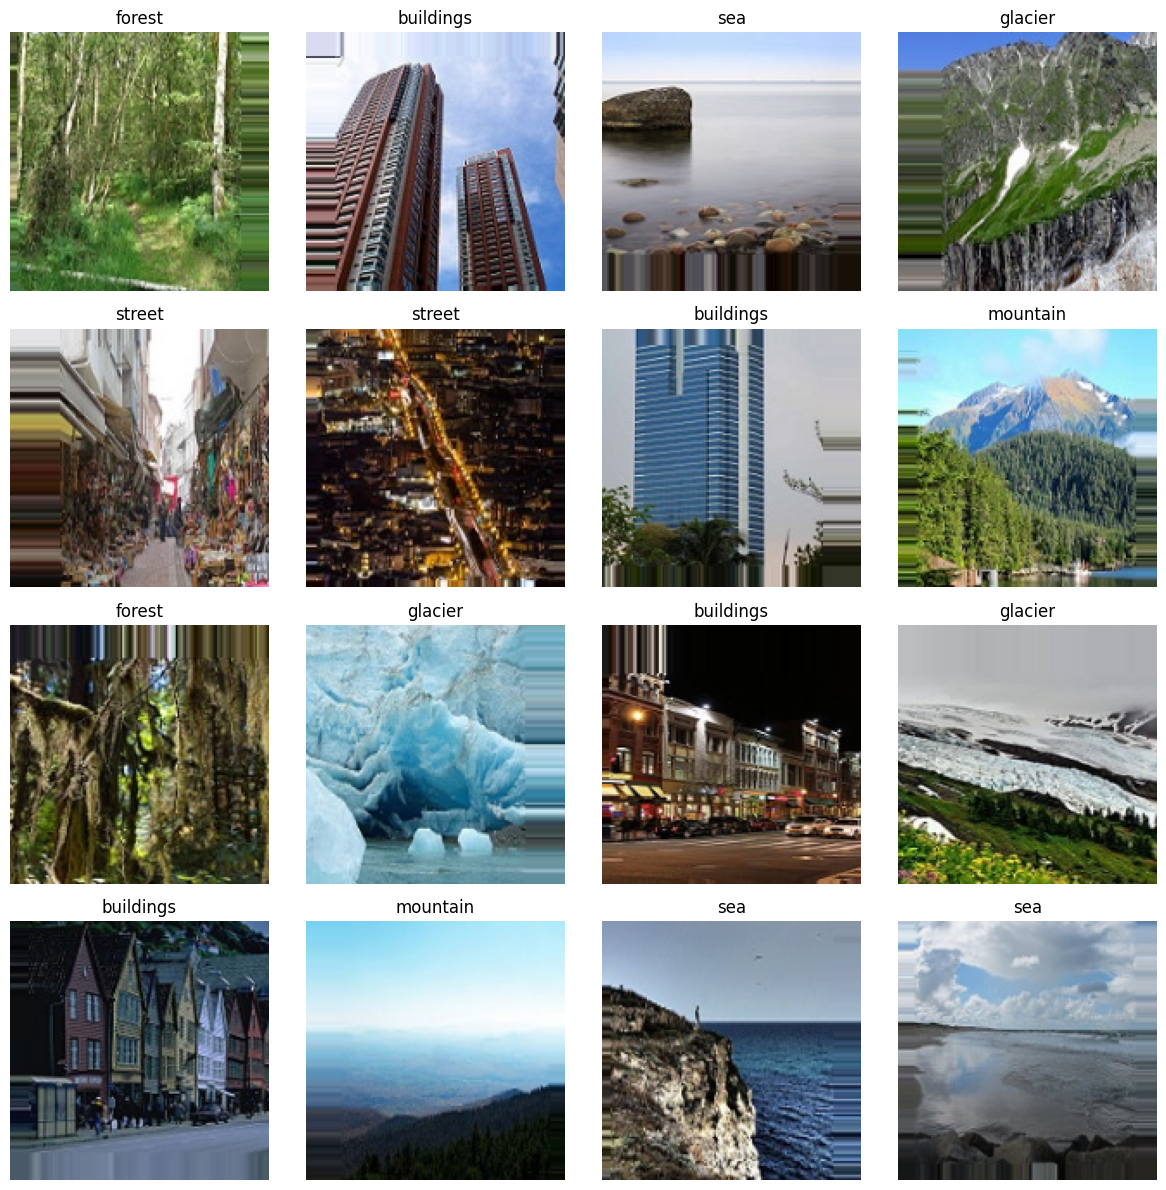

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
idx = 0

for i in range(4):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

# ResNet50: Pretrained model + customized top

In [12]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
base_resnet50 = ResNet50(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_resnet50.layers:
    layer.trainable = False

In [15]:
inputs = Input(shape=(150, 150, 3))
x = base_resnet50(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_resnet50 = Model(inputs, x)
model_resnet50.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                           

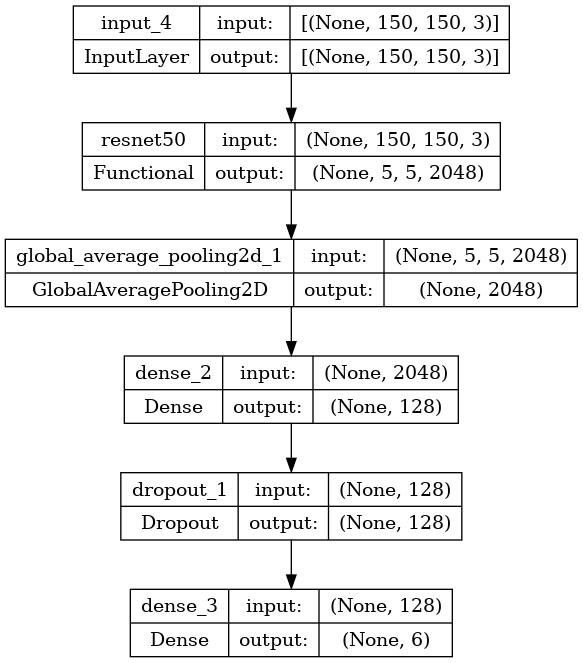

In [16]:
plot_model(model_resnet50, show_shapes = True)

In [17]:
model_resnet50.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_rn50 = model_resnet50.fit(train_generator, validation_data = val_generator, epochs=15,callbacks=callbacks)

Epoch 1/15
88/88 [==============================] - 177s 2s/step - loss: 1.7211 - accuracy: 0.2648 - val_loss: 1.6180 - val_accuracy: 0.3352
Epoch 2/15
88/88 [==============================] - 95s 1s/step - loss: 1.5386 - accuracy: 0.3752 - val_loss: 1.4562 - val_accuracy: 0.4169
Epoch 3/15
88/88 [==============================] - 98s 1s/step - loss: 1.4244 - accuracy: 0.4142 - val_loss: 1.3828 - val_accuracy: 0.4422
Epoch 4/15
88/88 [==============================] - 96s 1s/step - loss: 1.3467 - accuracy: 0.4544 - val_loss: 1.3134 - val_accuracy: 0.4932
Epoch 5/15
88/88 [==============================] - 95s 1s/step - loss: 1.2968 - accuracy: 0.4715 - val_loss: 1.2827 - val_accuracy: 0.4554
Epoch 6/15
88/88 [==============================] - 95s 1s/step - loss: 1.2425 - accuracy: 0.4956 - val_loss: 1.2301 - val_accuracy: 0.4996
Epoch 7/15
88/88 [==============================] - 95s 1s/step - loss: 1.2241 - accuracy: 0.5072 - val_loss: 1.1880 - val_accuracy: 0.5232
Epoch 8/15
88/88 [=

In [18]:
acc_rn50 = history_rn50.history['accuracy']
val_acc_rn50 = history_rn50.history['val_accuracy']
loss_rn50 = history_rn50.history['loss']
val_loss_rn50 = history_rn50.history['val_loss']

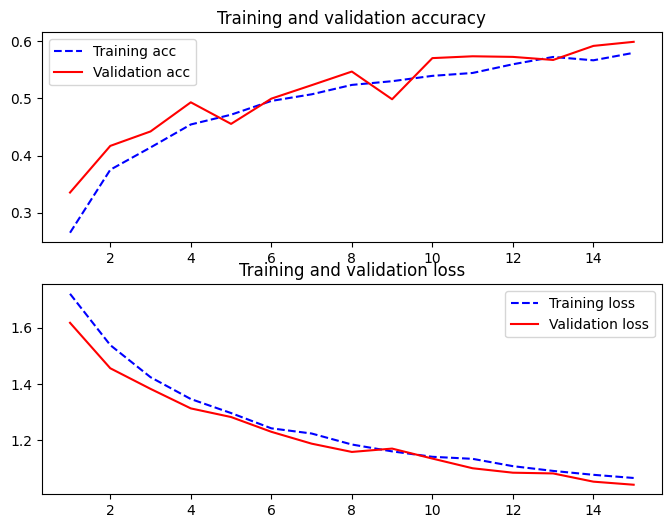

In [20]:
fig, ax = plt.subplots(2, 1, figsize = (8, 6))

epochs = range(1, len(acc_rn50) + 1)
ax[0].plot(epochs, acc_rn50, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_rn50, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_rn50, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_rn50, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [21]:
pred_resnet50 = model_resnet50.predict(test_generator)
y_test = test_generator.classes
y_pred_resnet50 = np.argmax(pred_resnet50, axis=1)

24/24 [==============================] - 24s 1s/step


In [48]:
rn_acc = accuracy_score(y_test,y_pred_resnet50)

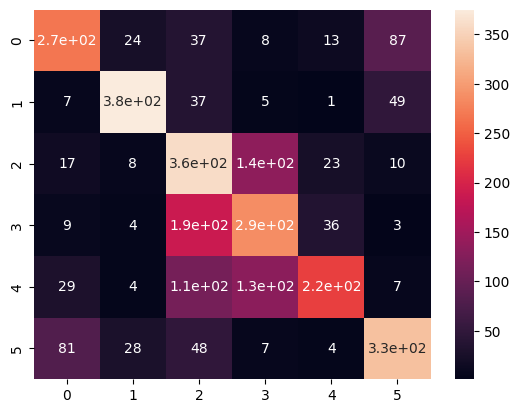

In [22]:
sns.heatmap(confusion_matrix(y_test,y_pred_resnet50),
            annot=True)
plt.show()

# EfficientNetV2: Pretrained model + customized top

In [23]:
base_effnet = EfficientNetV2B2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_effnet.layers:
    layer.trainable = False

35839040/35839040 [==============================] - 0s 0us/step


In [24]:
inputs = Input(shape=(150, 150, 3))
x = base_effnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_effnet = Model(inputs, x)
model_effnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b2 (Function  (None, 5, 5, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_2   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               180352    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 774 

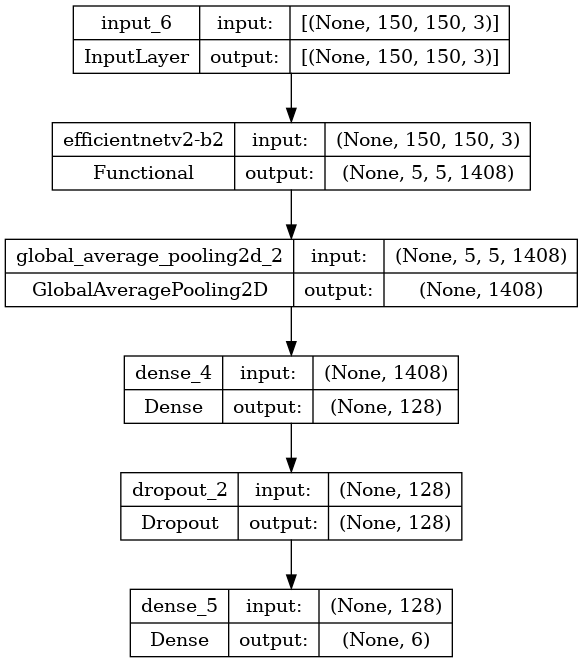

In [25]:
plot_model(model_effnet, show_shapes = True)

In [26]:
model_effnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_ef = model_effnet.fit(train_generator, validation_data = val_generator, epochs=15,callbacks=callbacks)

Epoch 1/15
88/88 [==============================] - 103s 1s/step - loss: 1.7913 - accuracy: 0.1957 - val_loss: 1.7711 - val_accuracy: 0.1815
Epoch 2/15
88/88 [==============================] - 90s 1s/step - loss: 1.7616 - accuracy: 0.2231 - val_loss: 1.7413 - val_accuracy: 0.2885
Epoch 3/15
88/88 [==============================] - 88s 1s/step - loss: 1.7218 - accuracy: 0.2467 - val_loss: 1.6937 - val_accuracy: 0.2807
Epoch 4/15
88/88 [==============================] - 99s 1s/step - loss: 1.6766 - accuracy: 0.2705 - val_loss: 1.6687 - val_accuracy: 0.3014
Epoch 5/15
88/88 [==============================] - 97s 1s/step - loss: 1.6491 - accuracy: 0.2781 - val_loss: 1.6177 - val_accuracy: 0.3078
Epoch 6/15
88/88 [==============================] - 93s 1s/step - loss: 1.6111 - accuracy: 0.2931 - val_loss: 1.6097 - val_accuracy: 0.3131
Epoch 7/15
88/88 [==============================] - 89s 1s/step - loss: 1.5925 - accuracy: 0.2962 - val_loss: 1.5888 - val_accuracy: 0.2903
Epoch 8/15
88/88 [=

In [27]:
acc_ef = history_ef.history['accuracy']
val_acc_ef = history_ef.history['val_accuracy']
loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

In [28]:
pred_ef = model_effnet.predict(test_generator)
y_test = test_generator.classes
y_pred_ef = np.argmax(pred_ef, axis=1)

24/24 [==============================] - 8s 268ms/step


In [58]:
effn_acc = accuracy_score(y_test,y_pred_ef)
effn_acc

0.3606666666666667

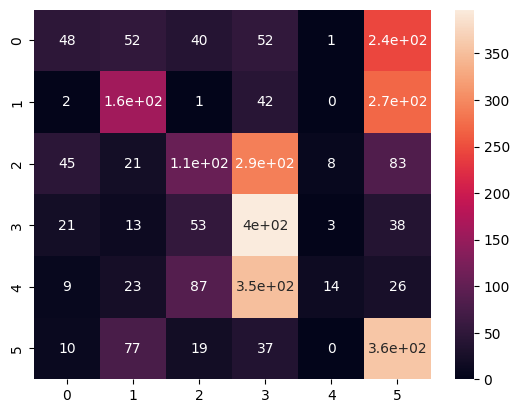

In [31]:
sns.heatmap(confusion_matrix(y_test,y_pred_ef),
            annot=True)
plt.show()

# MobileNetV2: Pretrained model + customized top

In [29]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2
base_mn = MobileNetV2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_mn.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [30]:
inputs = Input(shape=(150, 150, 3))
x = base_mn(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_mnet = Model(inputs, x)
model_mnet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774 

In [32]:
model_mnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_mn = model_mnet.fit(train_generator, validation_data = val_generator, epochs=15,callbacks=callbacks)

Epoch 1/15
88/88 [==============================] - 94s 1s/step - loss: 0.5341 - accuracy: 0.8025 - val_loss: 0.3498 - val_accuracy: 0.8727
Epoch 2/15
88/88 [==============================] - 87s 992ms/step - loss: 0.3609 - accuracy: 0.8654 - val_loss: 0.3530 - val_accuracy: 0.8691
Epoch 3/15
88/88 [==============================] - 87s 996ms/step - loss: 0.3286 - accuracy: 0.8742 - val_loss: 0.3596 - val_accuracy: 0.8602
Epoch 4/15
88/88 [==============================] - 87s 995ms/step - loss: 0.3124 - accuracy: 0.8846 - val_loss: 0.2993 - val_accuracy: 0.8869
Epoch 5/15
88/88 [==============================] - 90s 1s/step - loss: 0.2994 - accuracy: 0.8887 - val_loss: 0.2954 - val_accuracy: 0.8909
Epoch 6/15
88/88 [==============================] - 92s 1s/step - loss: 0.2863 - accuracy: 0.8926 - val_loss: 0.3101 - val_accuracy: 0.8937
Epoch 7/15
88/88 [==============================] - 88s 1s/step - loss: 0.2831 - accuracy: 0.8958 - val_loss: 0.3138 - val_accuracy: 0.8852
Epoch 8/15


In [33]:
acc_mn = history_mn.history['accuracy']
val_acc_mn = history_mn.history['val_accuracy']
loss_mn = history_mn.history['loss']
val_loss_mn = history_mn.history['val_loss']

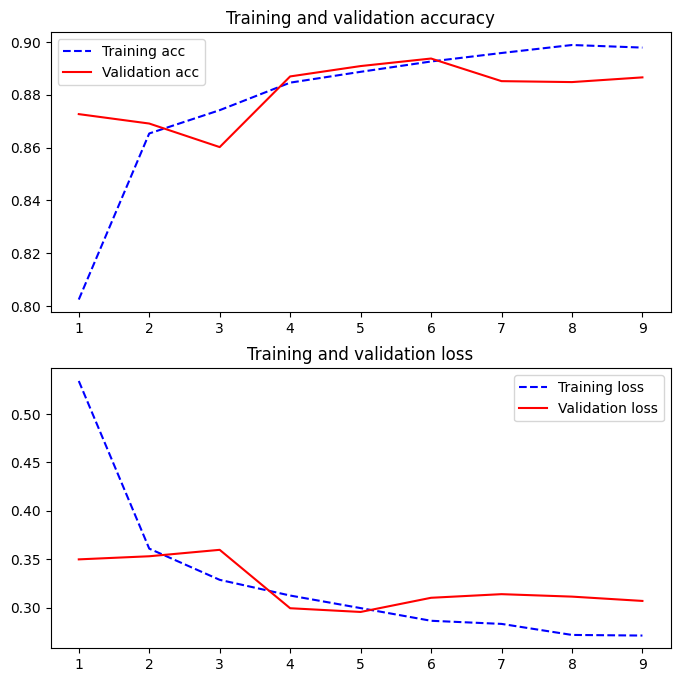

In [37]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_mn) + 1)
ax[0].plot(epochs, acc_mn, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_mn, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_mn, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_mn, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [34]:
pred_mn = model_mnet.predict(test_generator)
y_test = test_generator.classes
y_pred_mn = np.argmax(pred_mn, axis=1)

24/24 [==============================] - 7s 256ms/step


In [52]:
mn_acc = accuracy_score(y_test,y_pred_mn)
mn_acc

0.905

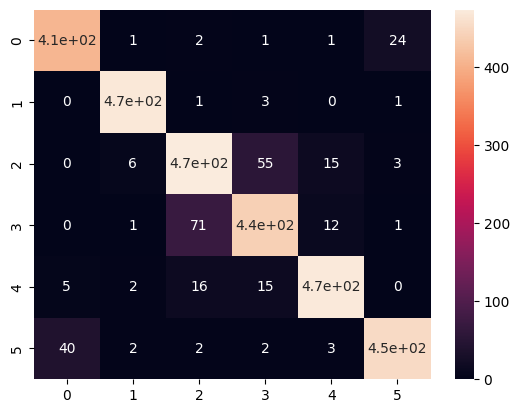

In [35]:
sns.heatmap(confusion_matrix(y_test,y_pred_mn),
            annot=True)
plt.show()

# VGG16 model: Pretrained model + customized top

In [38]:
base_VGG16 = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_VGG16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [39]:
inputs = Input(shape=(150, 150, 3))
x = base_VGG16(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

model_vgg16 = Model(inputs, x)
model_vgg16.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                           

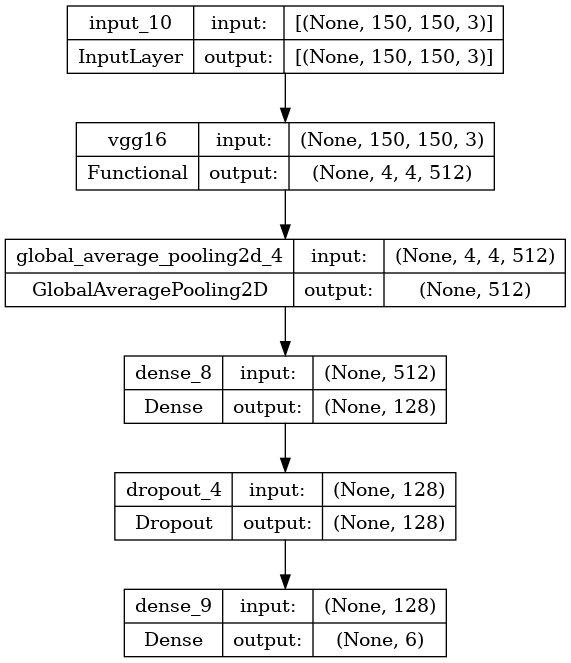

In [40]:
plot_model(model_vgg16, show_shapes=True)

In [41]:
model_vgg16.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model_vgg16.fit(train_generator, validation_data = val_generator, epochs=12,
                callbacks=callbacks)

Epoch 1/12
88/88 [==============================] - 117s 1s/step - loss: 0.9872 - accuracy: 0.6386 - val_loss: 0.6364 - val_accuracy: 0.7782
Epoch 2/12
88/88 [==============================] - 97s 1s/step - loss: 0.6014 - accuracy: 0.7848 - val_loss: 0.5442 - val_accuracy: 0.7924
Epoch 3/12
88/88 [==============================] - 96s 1s/step - loss: 0.5352 - accuracy: 0.8045 - val_loss: 0.4880 - val_accuracy: 0.8224
Epoch 4/12
88/88 [==============================] - 97s 1s/step - loss: 0.4984 - accuracy: 0.8215 - val_loss: 0.4725 - val_accuracy: 0.8267
Epoch 5/12
88/88 [==============================] - 99s 1s/step - loss: 0.4770 - accuracy: 0.8221 - val_loss: 0.4535 - val_accuracy: 0.8345
Epoch 6/12
88/88 [==============================] - 95s 1s/step - loss: 0.4656 - accuracy: 0.8314 - val_loss: 0.4456 - val_accuracy: 0.8295
Epoch 7/12
88/88 [==============================] - 98s 1s/step - loss: 0.4498 - accuracy: 0.8377 - val_loss: 0.4336 - val_accuracy: 0.8352
Epoch 8/12
88/88 [=

In [42]:
acc_vgg = history.history['accuracy']
val_acc_vgg = history.history['val_accuracy']
loss_vgg = history.history['loss']
val_loss_vgg = history.history['val_loss']

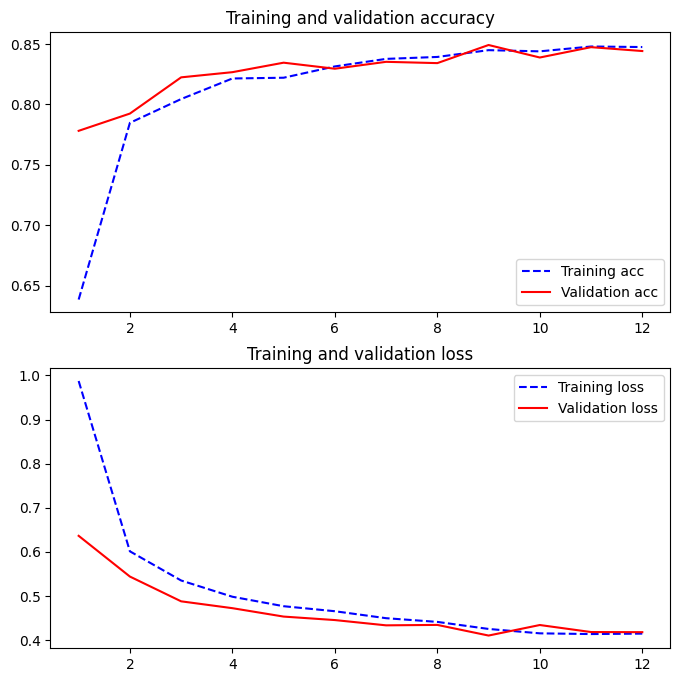

In [43]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_vgg) + 1)
ax[0].plot(epochs, acc_vgg, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_vgg, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_vgg, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_vgg, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [44]:
pred_vgg16 = model_vgg16.predict(test_generator)
y_test = test_generator.classes
y_pred_vgg16 = np.argmax(pred_vgg16, axis=1)

24/24 [==============================] - 12s 513ms/step


In [53]:
vgg16_acc = accuracy_score(y_test,y_pred_vgg16)
vgg16_acc

0.8576666666666667

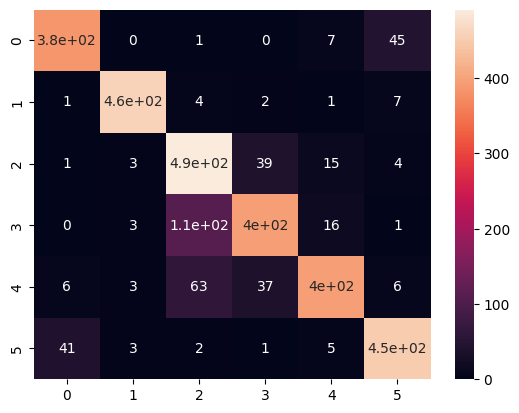

In [45]:
sns.heatmap(confusion_matrix(y_test,y_pred_vgg16),
            annot=True)
plt.show()

# Comparison of accuracy

In [59]:
vgg16_acc, mn_acc, rn_acc, effn_acc

(0.8576666666666667, 0.905, 0.6156666666666667, 0.3606666666666667)

In [65]:
d  = pd.DataFrame({'Model': ['EfficientNetV2', 'ResNet50','VGG16', 'MobileNetV2'], 
      'Accuracy': [effn_acc, rn_acc,  vgg16_acc,  mn_acc]})
d = d.set_index('Model')

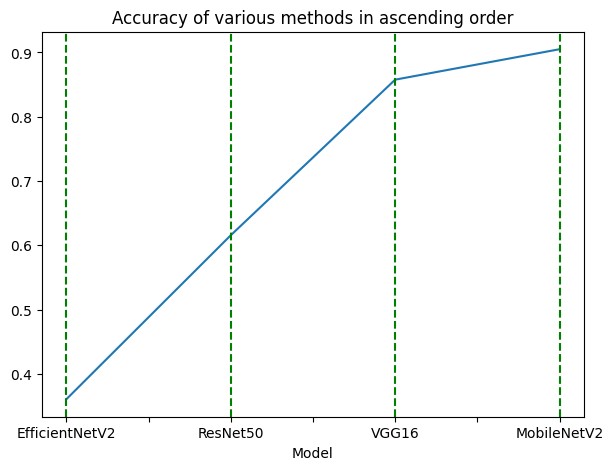

In [67]:
f, ax = plt.subplots(figsize = (7,5))
d['Accuracy'].sort_values(ascending = True).plot(ax = ax)
ax.axvline("EfficientNetV2", color="green", linestyle="dashed")
ax.axvline("ResNet50", color="green", linestyle="dashed")
ax.axvline("VGG16", color="green", linestyle="dashed")
ax.axvline("MobileNetV2", color="green", linestyle="dashed")
plt.title('Accuracy of various methods in ascending order');